## Planejamento da solução (IOT)

### Input - Entrada

1. Problema de negócio
    - Selecionar os clientes mais valiosos para integrar um programa de fidelização
    
    
2. Conjunto de dados
    - Vendas de um e-comerce online, durante o período de um ano

### Output - Saída

1. A indicação das pessoas que farão parte do programa de Insiders
    - Lista: client_id | is_insider
                10254  | yes
                88347  | no
                
2. Relatório com as respostas das pergumtas de negócio

    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    
    - Quantos clientes farão parte do grupo?
    
    - Quais as principais características desses clientes ?
    
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    
    - Quais as condições para uma pessoa ser removida do Insiders ?
    
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

### Tasks - Tarefas

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - O que é ser elegível? O que são clientes de maior "valor"?
    - Faturamento:
        - Alto ticket médio.
        - Alto LTV.
        - Baixa recência.
        - Alto basket size.
        - Baixa probabilidade de churn.
        - Alta previsão LTV.
        - Alta propensão de compra.
        
    - Custo:
        - Baixa taxa de devolução.
        
    - Experiencia de compra:
        - Média alta de avaliação
        

2. Quantos clientes farão parte do grupo?
    - Número total de clientes;
    - % do grupo Insiders
    

3. Quais as principais características desses clientes ?
    - Escrever características do cliente:
        - Idade;
        - Localização;
        - País;
        
    - Escrever caracteristicas do consumo:
        - Atributos da clusterização


4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Faturamento total do ano;
    - Faturamento do grupo Insiders;


5. Qual a expectativa de faturamento desse grupo para os próximos meses ?
     - LTV do grupo Insiders;
     - Análise de Cohort;
     - Séries temporais (ARIMA, HoltWinter);


6. Quais as condições para uma pessoa ser elegível ao Insiders ?
     - Definir a periodicidade (1 mês, 3 mêses);
     - A pessoa precsa ser similar ou parecido com uma pessoa do grupo
     

7. Quais as condições para uma pessoa ser removida do Insiders ?
    - Definir a periodicidade (1 mês, 3 mêses);
    - A pessoa precisa ser desimilar ou não-parecido com uma pessoa do grupo


8. Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Teste A/B
    - Teste A/B Bayesiano
    - Teste de hipóteses


9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Desconto;
    - Preferencia de compra;
    - Produtos exclusivos

# 0.0 Imports

In [1]:
import pandas            as pd
import numpy             as np
import seaborn           as sns
import umap.umap_ as umap
from sklearn import mixture as mx
from scipy.cluster import hierarchy as hc
from matplotlib          import pyplot as plt
from IPython.display     import HTML
from sklearn             import cluster as c
from sklearn import metrics as m
from pandas_profiling import ProfileReport
from sklearn.manifold import TSNE
from plotly import express as px
from sklearn import ensemble 
from sklearn import preprocessing as pp
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [18, 9]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Load Data

In [3]:
df_raw = pd.read_csv('../data/Ecommerce.csv')

In [4]:
# droping extra column
df_raw.drop(columns=['Unnamed: 8'], axis=1, inplace=True)

# 1.0 Data Description

In [5]:
df1 = df_raw.copy()

## 1.1 Rename columns

In [6]:
df1.columns = ['invoice_no','stock_code','description','quantity','invoice_date','unit_price','customer_id','country']

## 1.2 Data Dimensions

In [7]:
df1.shape

(541909, 8)

## 1.3 Data types

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check Na

In [9]:
df1.isnull().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace Na

In [10]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [11]:
# create reference 
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id']  = np.arange(19000, 19000+len(df_backup),1)

# merge original with reference dataframe
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1 = df1.drop(columns=['customer_id_x','customer_id_y'], axis=1)

In [12]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6 Change Types

In [13]:
# invoice date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].astype('int64')

In [14]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7 Descriptive Statistics 

In [15]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(include='object')

### 1.7.1 Numerical Atributtes

In [16]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - min, max, range, std, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.min)).T
d2 = pd.DataFrame(num_attributes.apply(np.max)).T
d3 = pd.DataFrame(num_attributes.apply(np.std)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

a = pd.concat([d1,d2,d4,d3,ct1,ct2,d5,d6]).T.reset_index()

a.columns = ['attributes','min','max','range','std','mean','median','skew','kurtosis']
a

,attributes,min,max,range,std,mean,median,skew,kurtosis
0,quantity,-80995.000,80995.000,161990.000,218.081,9.552,3.000,-0.264,119769.160
1,unit_price,-11062.060,38970.000,50032.060,96.760,4.611,2.080,186.507,59005.719
2,customer_id,12346.000,22709.000,10363.000,2911.409,16688.840,16249.000,0.487,-0.804


#### 1.7.1.1 Num Attributes - Investigating

1. Quantidade negativa (pode ser devolução)
2. Preço unitário zero (pode ser promoção?)

### 1.7.2 Categorical Atributtes

In [17]:
# invoice number
len(cat_attributes.loc[cat_attributes['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'invoice_no'].drop_duplicates())

3839

In [18]:
# stock code
cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$',x))), 'stock_code'].unique()

# Ação: 1. Remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Description

In [19]:
# Ação: delete description

#### Country

In [20]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [21]:
df1['country'].value_counts(normalize=True).head()

United Kingdom   0.914
Germany          0.018
France           0.016
EIRE             0.015
Spain            0.005
Name: country, dtype: float64

In [22]:
df1[['customer_id','country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False).head()

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# 2.0 Variable Filtering

In [23]:
df2 = df1.copy()

In [24]:
# unit price > 0.0
df2 = df2.loc[df2['unit_price'] > 0.04, :]

# stock code != [POST, D, M, DOT, CRUK]
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# description
df2 = df2.drop(columns='description', axis=1)

# map
df2 = df2[~df2['country'].isin(['European Community','Unspecified'])]

# bad users
df2 = df2[~df2['customer_id'].isin([16446])]

# quantity - negative numbers means product returns
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchase = df2.loc[df2['quantity'] >0, :]

# 3.0 Feature Engineering

In [25]:
df3 = df2.copy()

## 3.1 Feature Creation

In [26]:
df_ref = df3.drop(['invoice_no','stock_code','quantity',
                   'invoice_date','unit_price','country'], axis=1).drop_duplicates(ignore_index=True)

### 3.1.1 Gross Revenue

In [27]:
# Gross Revenue (Faturamento)
df2_purchase.loc[:, 'gross_revenue'] =  df2_purchase.loc[:, 'quantity'] * df2_purchase.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchase.loc[:, ['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')
df_ref.isna().sum()

C:\Users\leona\anaconda3\envs\insiders_clustering\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\leona\anaconda3\envs\insiders_clustering\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2 Recency - Day from last purchase

In [28]:
# Recency - last day purchase
df_recency = df2_purchase.loc[:, ['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id','recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3 Quantity of purchase

In [29]:
# Numero de produtos
df_freq = (df2_purchase.loc[:, ['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no':'qtde_invoices'}))

df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
dtype: int64

### 3.1.4 Total quantity of items purchased

In [30]:
df_freq = (df2_purchase.loc[:, ['customer_id','quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qtde_items'}))
df_ref = pd.merge(df_ref, df_freq, on='customer_id',how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
dtype: int64

### 3.1.5 Quantity of products purchased

In [31]:
df_freq = (df2_purchase.loc[:, ['customer_id','stock_code']].groupby('customer_id').count().reset_index().rename(columns={'stock_code':'qtde_products'}))
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
dtype: int64

### 3.1.6 Avg ticket value

In [32]:
# Avg ticket
df_avg_ticket = df2_purchase.loc[:, ['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref,df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
avg_ticket       91
dtype: int64

### 3.1.7 Average Recency Days

In [33]:
df_aux = df2[['customer_id','invoice_date']].drop_duplicates().sort_values(['customer_id','invoice_date'], ascending=['False','False'])
df_aux['next_customer_id'] = df_aux['customer_id'].shift()
df_aux['previous_date'] = df_aux['invoice_date'].shift()

df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['invoice_date'] - x['previous_date']).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1)

df_aux = df_aux.drop(['invoice_date','next_customer_id','previous_date'], axis=1).dropna()

# avarege recency
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

#merge
df_ref = pd.merge(df_ref, df_avg_recency_days, on='customer_id', how='left')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
dtype: int64

### 3.1.8 Frequency Purchase

In [34]:
df_aux = (df2_purchase[['customer_id','invoice_no','invoice_date']].drop_duplicates().groupby('customer_id').agg(max_ = ('invoice_date','max'),
                                                                                                                 min_ = ('invoice_date','min'),
                                                                                                                 days_ = ('invoice_date', lambda x: ((x.max()-x.min()).days) +1),
                                                                                                                 buy_ = ('invoice_date','count'))).reset_index()
# frequency
df_aux['frequency'] = df_aux[['buy_','days_']].apply(lambda x: x['buy_']/x['days_'] if x['days_'] != 0 else 0, axis=1)

# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id','frequency']], on='customer_id', how='left')

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
dtype: int64

### 3.1.9 Number of returns

In [35]:
df_returns = df2_returns[['customer_id','quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qtde_returns'})
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge(df_ref, df_returns, how='left', on='customer_id')
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
dtype: int64

### 3.2.0 Basket Size - Quantidade de itens por cesta (quantity)

- Invoice no = compra = purchase
- Stock code = produto = product
- Quantity = item = item

In [36]:
df_aux = (df2_purchase.loc[:, ['customer_id','invoice_no','quantity']].groupby('customer_id').agg(n_purchase=('invoice_no','nunique'),
                                                                                                 n_products=('quantity','sum')).reset_index())

df_aux['avg_basket_size'] = df_aux['n_products']/df_aux['n_purchase']

df_ref = pd.merge(df_ref, df_aux[['customer_id','avg_basket_size']], how='left', on='customer_id')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
avg_basket_size       91
dtype: int64

### 3.2.1 Unique Basket Size - Quantidade de produtos distintos por compra

In [37]:
df_aux = (df2_purchase.loc[:, ['customer_id','invoice_no','stock_code']].groupby('customer_id').agg(n_purchase=('invoice_no','nunique'), 
                                                                                                     n_products=('stock_code','nunique')).reset_index())

df_aux['avg_unique_basket_size'] = df_aux['n_products']/df_aux['n_purchase']

df_ref = pd.merge(df_ref, df_aux[['customer_id','avg_unique_basket_size']], how='left', on='customer_id')
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtde_invoices               91
qtde_items                  91
qtde_products               91
avg_ticket                  91
avg_recency_days          2816
frequency                   91
qtde_returns                 0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

# 4.0 EDA

In [38]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtde_invoices             0
qtde_items                0
qtde_products             0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## 4.1 Univariate Analysis

**Notas**
- Em clusters olhar para a variabilidade das features - procurar features que tenham maior variabilidade
1. No pandas profiling olhar para **métricas**:
    - Min, máx, range (disperção)
    - Média e mediana
    - Desvio padrão e variância
    - Coeficiente de variação (CV) - procurar cv alto
    - Distribuição

In [39]:
#profile = ProfileReport(df4)
#profile.to_file('output_v2.html')

### 4.1.1 Gross Revenue

In [40]:
df4[df4['customer_id'] == 14646]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.020,1.000,72.000,196844.000,2060.000,135.504,7.844,0.203,288.000,2733.944,9.708


### 4.1.2 Qtde Itens

In [41]:
df4[df4['customer_id'] == 17841]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
68,17841,40959.720,1.000,124.000,22853.000,7837.000,5.226,3.321,0.332,203.000,184.298,10.653


### 4.1.3 Avg Ticket

In [42]:
df4[df4['avg_ticket'] == 56157.5]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size


In [43]:
df3[df3['customer_id'] == 16446]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id


## 4.2 Bivariate Analysis

In [44]:
cols = ['customer_id']
df4_aux = df4.drop(cols, axis=1)

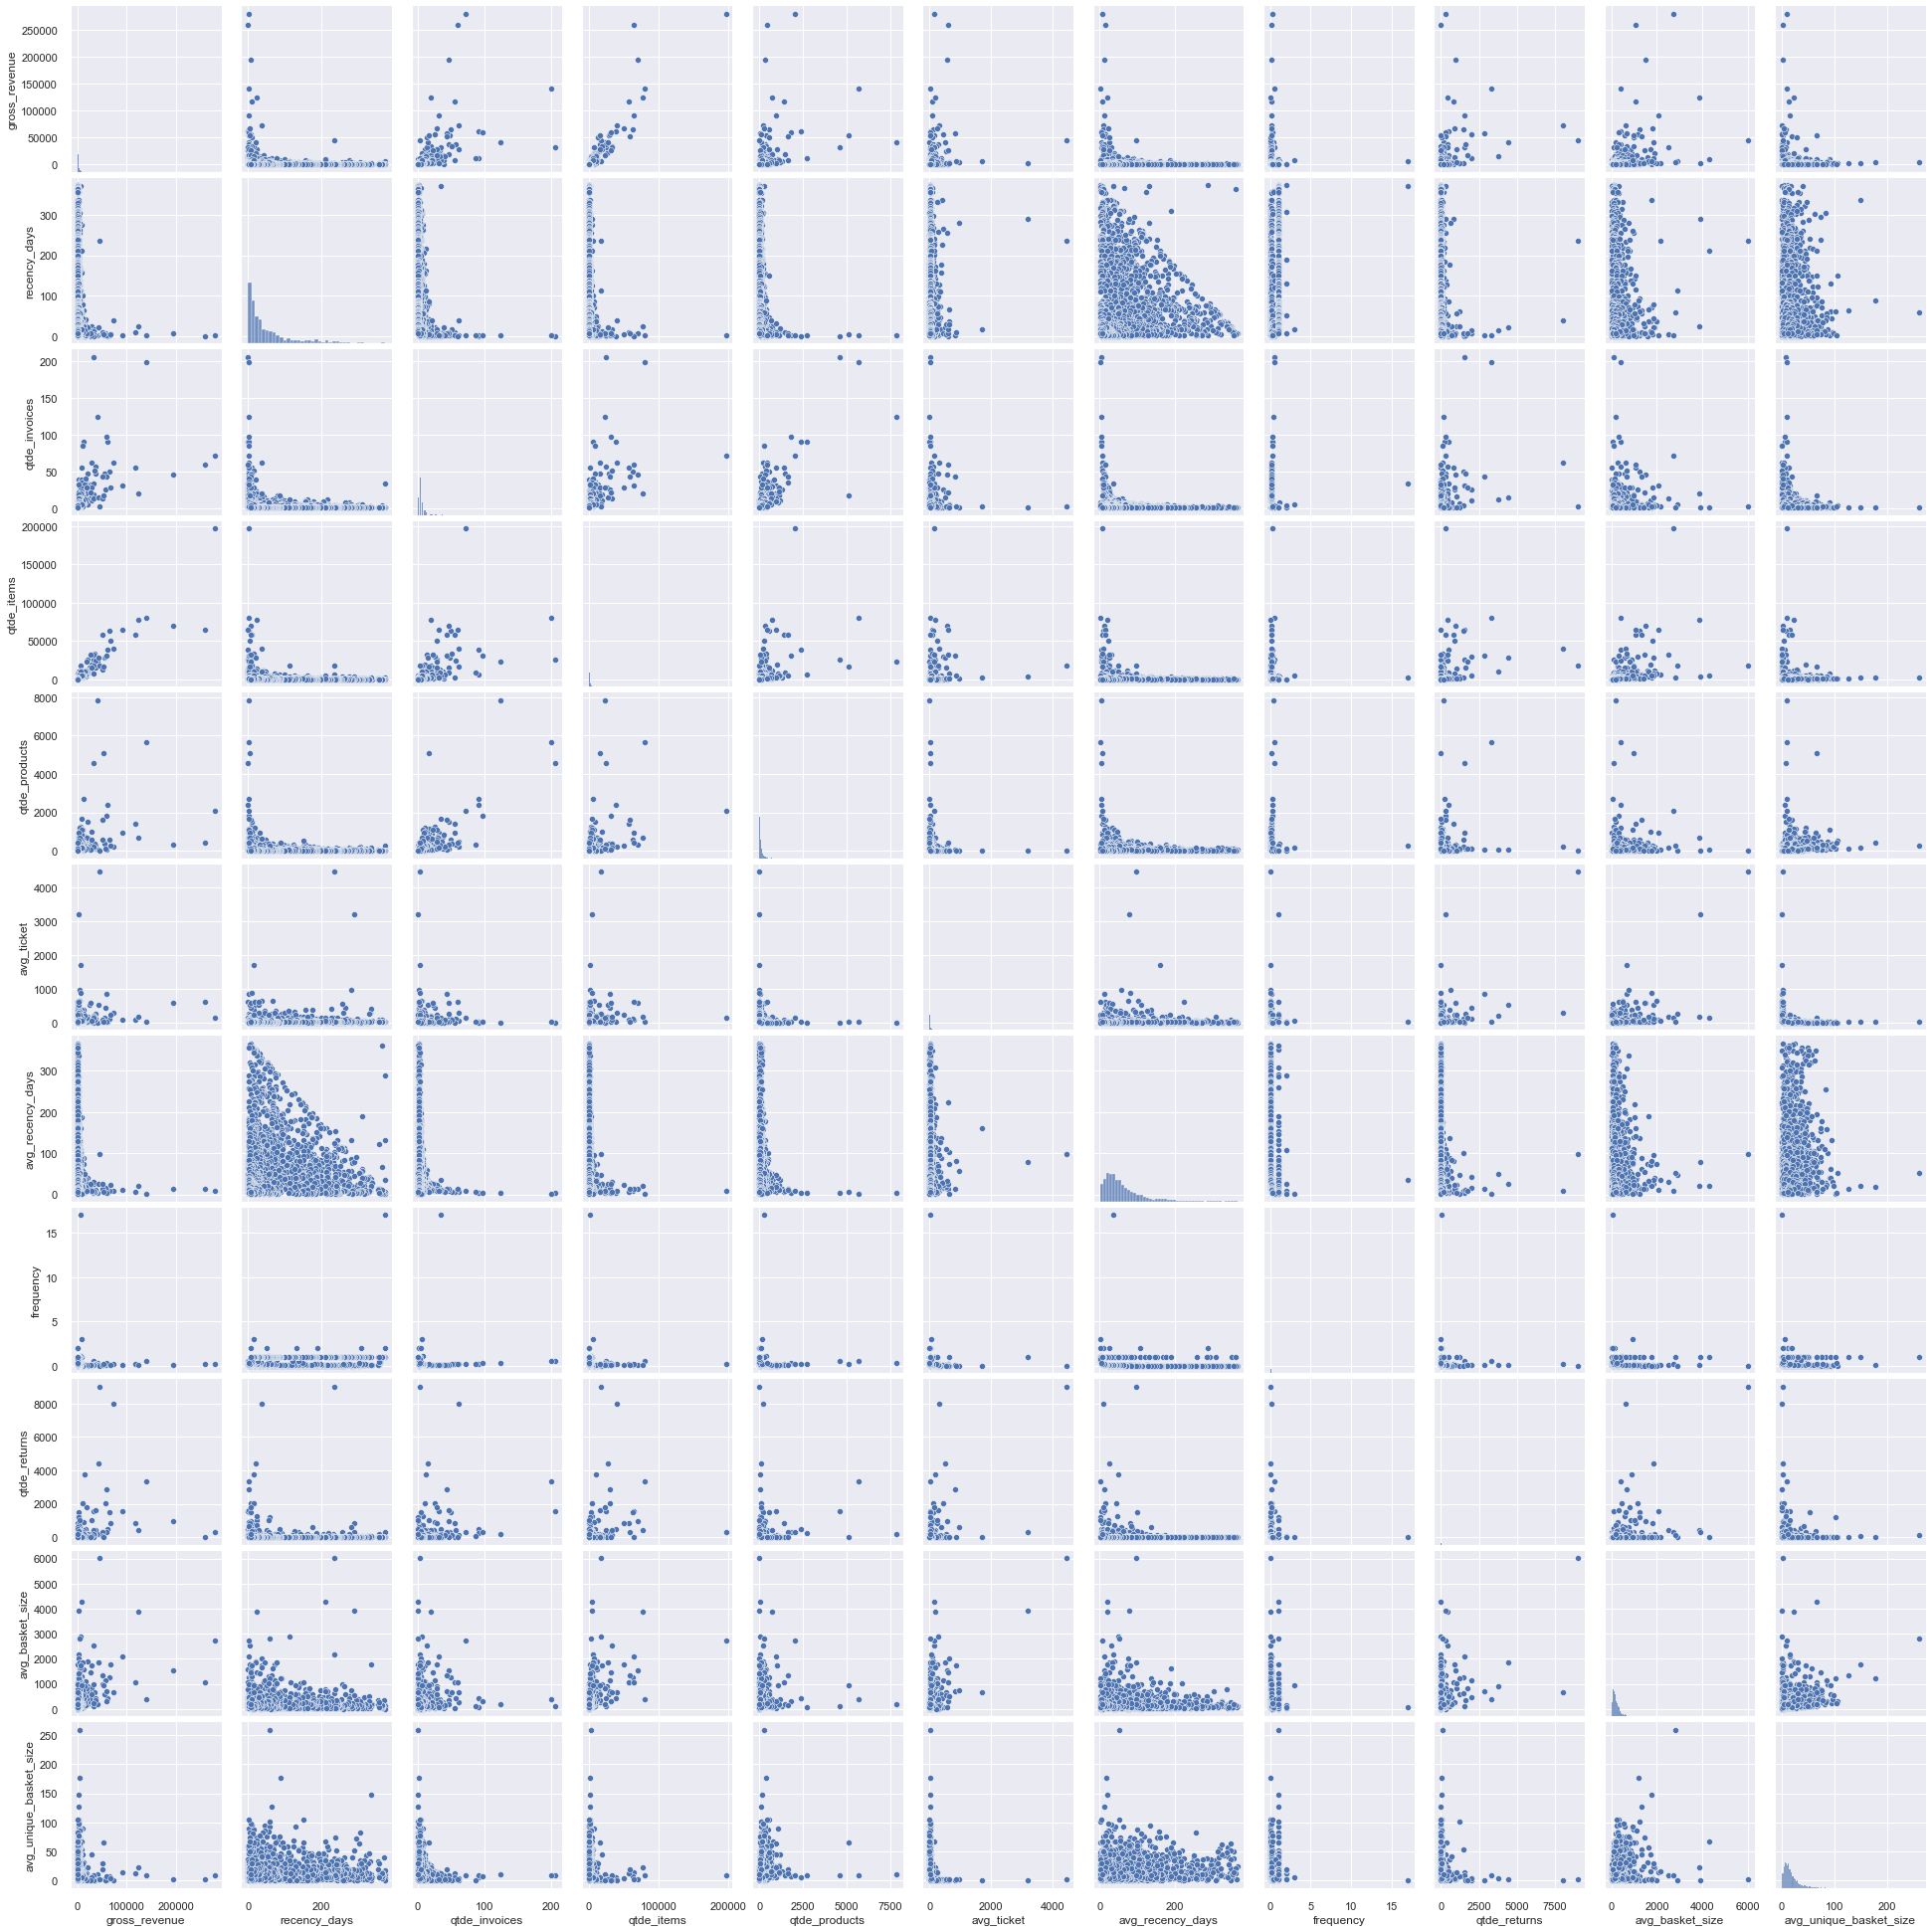

In [45]:
sns.pairplot(df4_aux)

**Notes**
1. Frequencia possui baixa variancia 
2. Avg ticket possuiu baixa variancia

## 4.3 Estudo do Espaço

In [46]:
# original dataset
#df43 = df4.drop(columns=['customer_id'], axis=1).copy()

# select dataset
cols_selected = ['customer_id','gross_revenue','recency_days','qtde_products','frequency','qtde_returns']
df43 = df4[cols_selected].copy()

In [47]:
mm = pp.MinMaxScaler()

df43['gross_revenue'] = mm.fit_transform(df43[['gross_revenue']])
df43['recency_days'] = mm.fit_transform(df43[['recency_days']])
#df43['qtde_invoices'] = mm.fit_transform(df43[['qtde_invoices']])
#df43['qtde_items'] = mm.fit_transform(df43[['qtde_items']])
df43['qtde_products'] = mm.fit_transform(df43[['qtde_products']])
#df43['avg_ticket'] = mm.fit_transform(df43[['avg_ticket']])
#df43['avg_recency_days'] = mm.fit_transform(df43[['avg_recency_days']])
df43['frequency'] = mm.fit_transform(df43[['frequency']])
df43['qtde_returns'] = mm.fit_transform(df43[['qtde_returns']])
#df43['avg_basket_size'] = mm.fit_transform(df43[['avg_basket_size']])
#df43['avg_unique_basket_size'] = mm.fit_transform(df43[['avg_unique_basket_size']])

X = df43.copy()

### 4.3.1 PCA

In [48]:
from sklearn import decomposition as dd

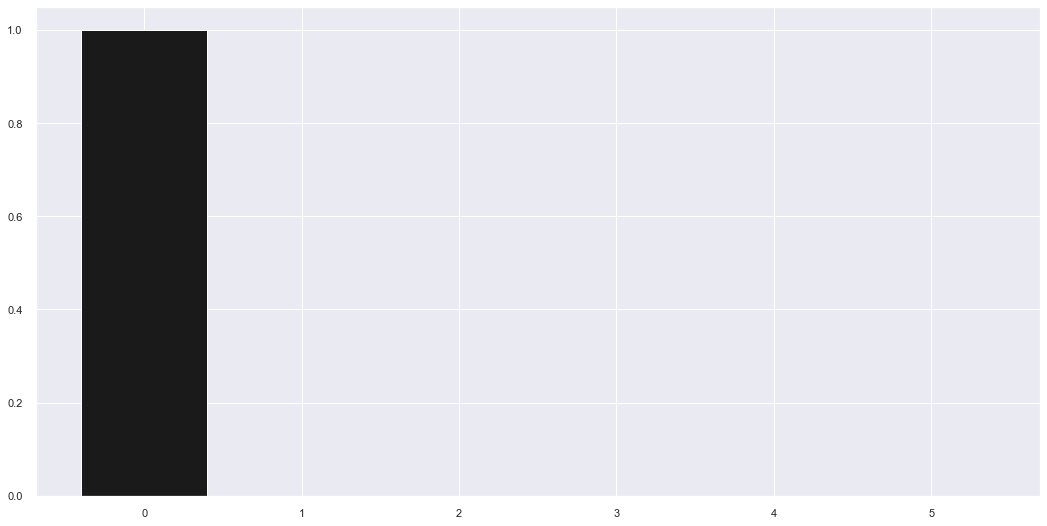

In [49]:
pca = dd.PCA(n_components=X.shape[1])

principal_components = pca.fit_transform(X)

# plot explained variables
faetures = range(pca.n_components_)

plt.bar(faetures, pca.explained_variance_ratio_, color='k')

# pca components
df_pca = pd.DataFrame(principal_components)

<AxesSubplot:xlabel='0', ylabel='1'>

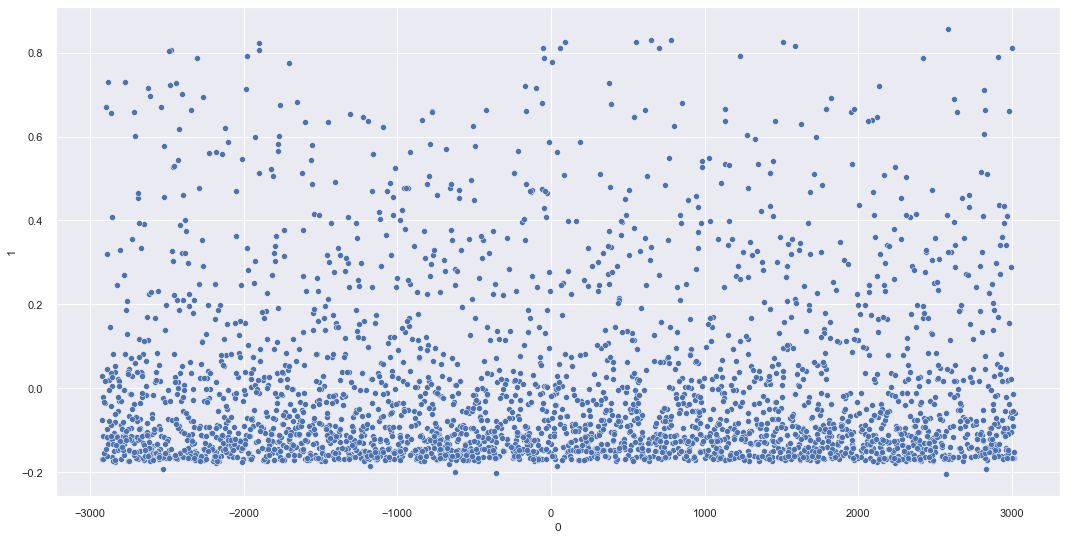

In [50]:
sns.scatterplot(x=0, y=1, data=df_pca)

### 4.3.2 UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

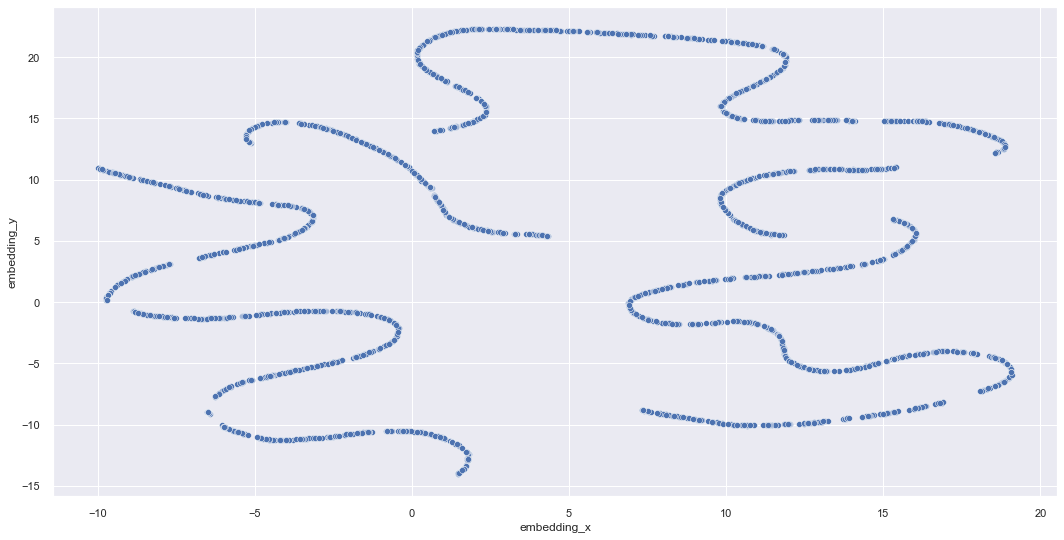

In [51]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_pca)

### 4.3.3 t-SNE

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

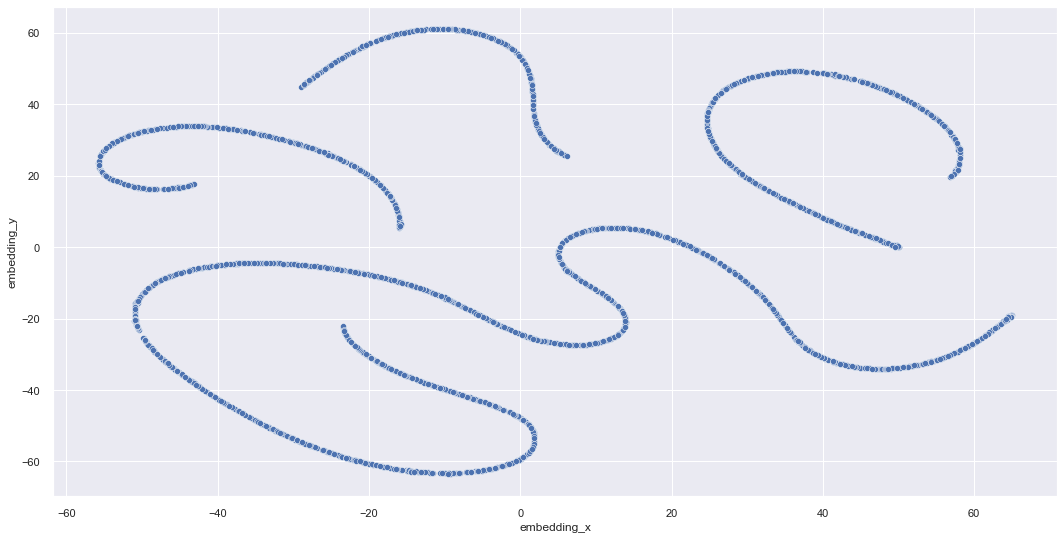

In [52]:
reducer = TSNE(n_components= 2, random_state=42, n_jobs=-1)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_pca)

### 4.3.4 Tree based embedding

In [53]:
X = df43.drop(columns=['customer_id','gross_revenue'], axis=1)
y = df43['gross_revenue']

# model definition
rf_model = ensemble.RandomForestRegressor(n_estimators=100, random_state=42)

# model training
rf_model.fit(X,y)

# dataframe leaf
df_leaf = pd.DataFrame(rf_model.apply(X))

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

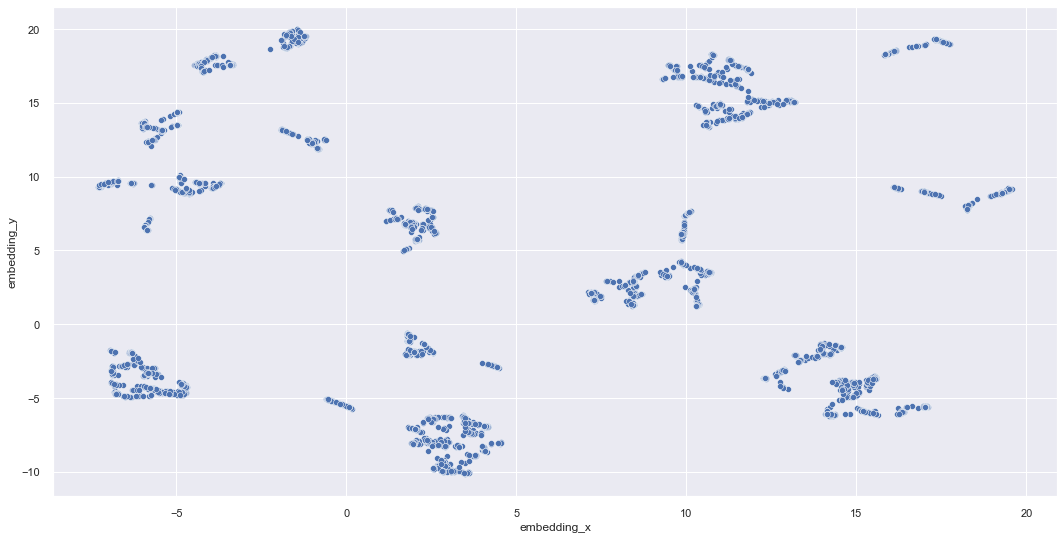

In [54]:
# reduzir dimensionalidade

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_tree)

# 5.0 Data Preparation

In [55]:
df5 = df4.copy()
df5 = df_tree.copy()

In [56]:
## MinMaxScaler Scaler
#mm = pp.MinMaxScaler()

#df5['gross_revenue'] = mm.fit_transform(df5[['gross_revenue']])
#df5['recency_days'] = mm.fit_transform(df5[['recency_days']])
#df5['qtde_invoices'] = mm.fit_transform(df5[['qtde_invoices']])
#df5['qtde_items']  = mm.fit_transform(df5[['qtde_items']])
#df5['qtde_products'] = mm.fit_transform( df5[['qtde_products']] )
#df5['avg_ticket'] = mm.fit_transform( df5[['avg_ticket']] )
#df5['avg_recency_days'] = mm.fit_transform( df5[['avg_recency_days']] )
#df5['frequency'] = mm.fit_transform( df5[['frequency']] )
#df5['qtde_returns'] = mm.fit_transform( df5[['qtde_returns']] )
#df5['avg_basket_size'] = mm.fit_transform( df5[['avg_basket_size']] )
#df5['avg_unique_basket_size'] = mm.fit_transform( df5[['avg_unique_basket_size']] )

# 6.0 Feature Selection

In [57]:
#cols_selected = ['customer_id','gross_revenue','recency_days','qtde_products','frequency','qtde_returns']

In [58]:
#df6 = df5[cols_selected].copy()
df6 = df_tree.copy()

# 7.0 Hyperparameter Fine_Tunning

In [59]:
#X = df6.drop(columns=['customer_id'])
X = df_tree.copy()

In [60]:
X.head()

,embedding_x,embedding_y
0,11.351,16.477
1,18.303,8.047
2,11.598,17.452
3,2.455,7.087
4,-4.883,9.617


In [61]:
clusters = np.arange(2,25,1)

## 7.1 K-Means

In [62]:
kmeans_list = []

for k in clusters:
    # model definition
    kmeans_model = c.KMeans(n_clusters=k)
    
    # model training
    kmeans_model.fit(X)
    
    # model predict
    labels = kmeans_model.predict(X)
    
    # model performance
    sil= m.silhouette_score(X, labels, metric='euclidean')
    kmeans_list.append(sil)
    

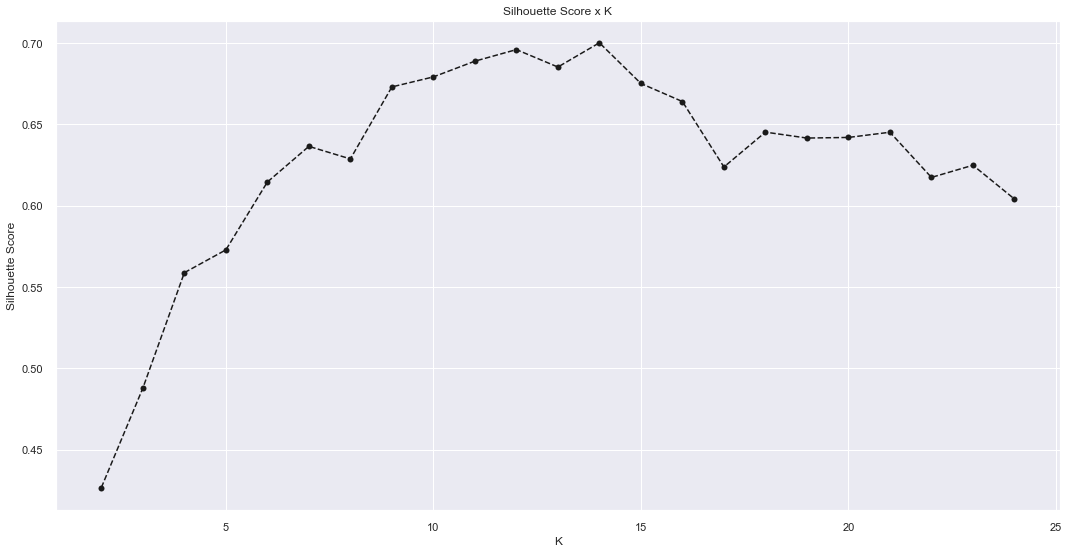

In [63]:
plt.plot(clusters, kmeans_list, linestyle='--', marker='o', color='k')
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score x K');

## 7.2 GMM

In [64]:
gmm_list = []

for k in clusters:
    # model definiton
    gmm_model = mx.GaussianMixture(n_components=k)

    # model training
    gmm_model.fit(X)

    # model predict
    labels = gmm_model.predict(X)

    # model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    gmm_list.append(sil)

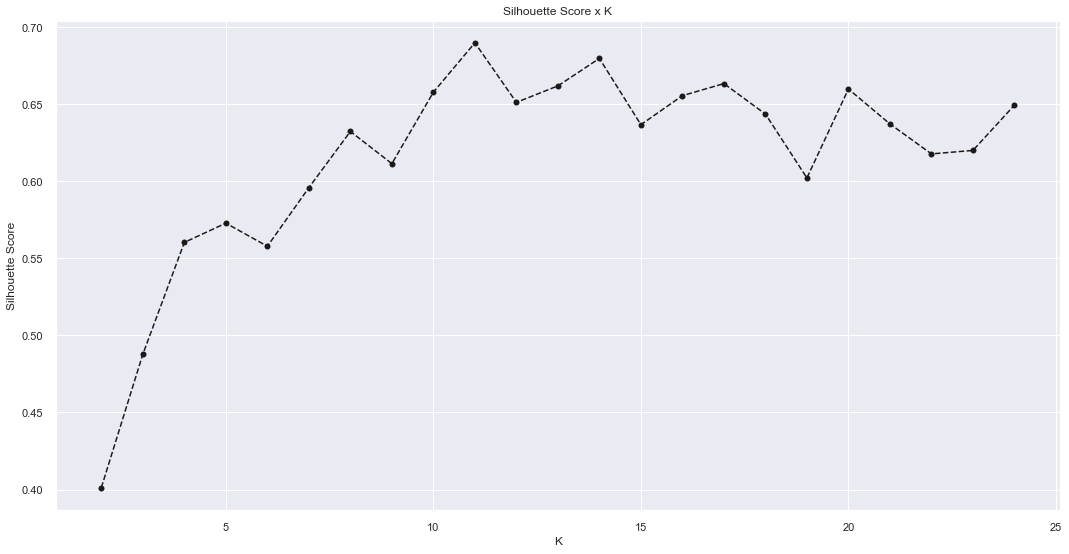

In [65]:
plt.plot(clusters, gmm_list, linestyle='--', marker='o', color='k')
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score x K');

## 7.3 Hierarchical Clustering

In [66]:
hc_model = hc.linkage(X, 'ward')

[]

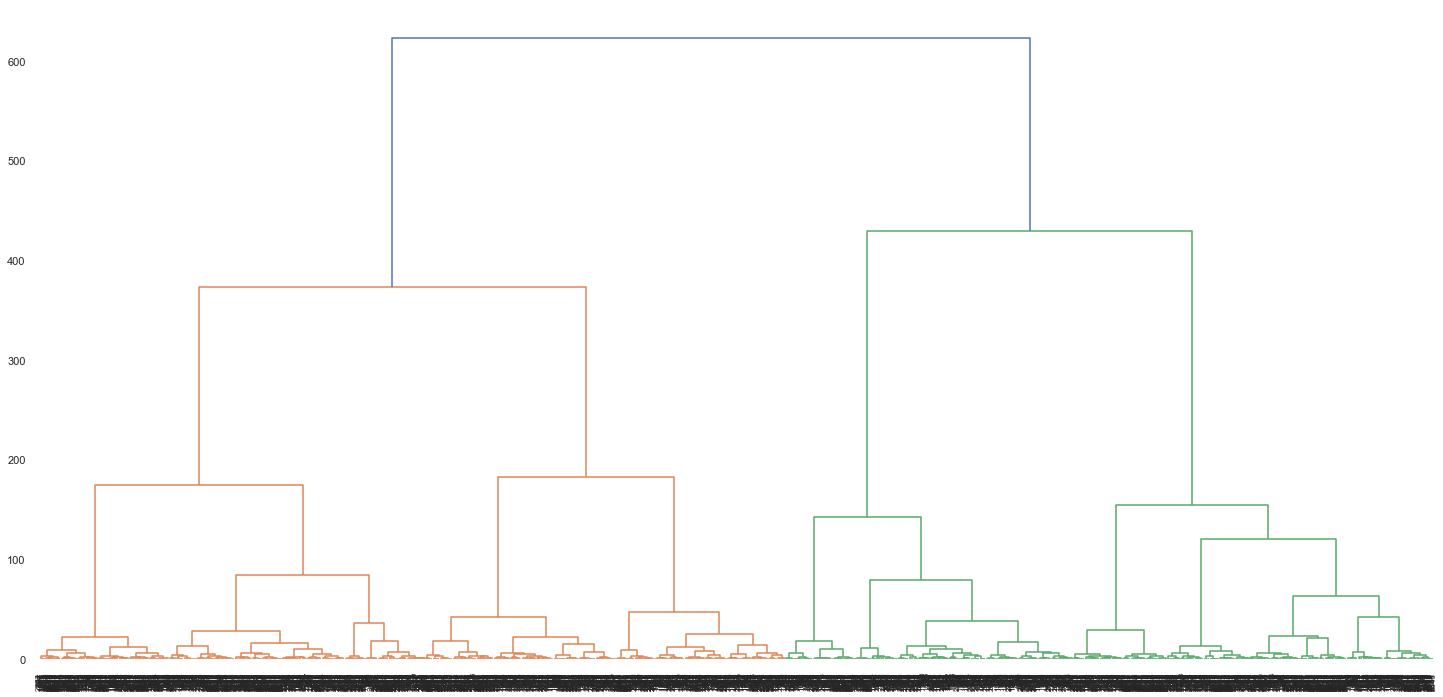

In [67]:
plt.figure(figsize=(25,12))

hc.dendrogram(hc_model, leaf_rotation=90, leaf_font_size=8);

plt.plot()

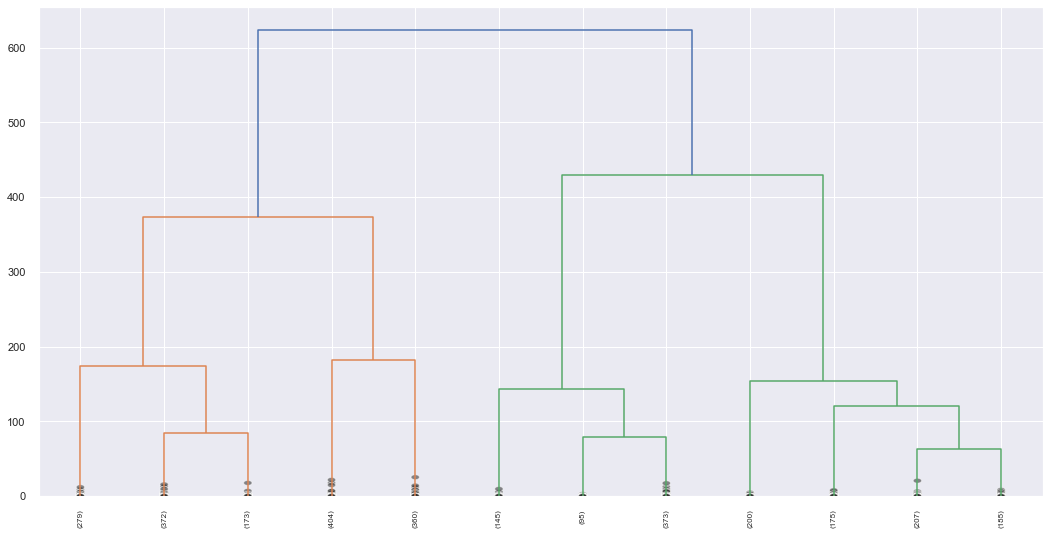

In [68]:
hc.dendrogram(hc_model, truncate_mode='lastp', p=12, leaf_rotation=90, leaf_font_size=8, show_contracted=True)
plt.show()

### 7.3.1 HClustering Silhouette Score

In [69]:
hc_list = []

for k in clusters:
    # model definiton & training
    hc_model = hc.linkage(X, 'ward')
    
    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')
    
    # metrics
    sil = m.silhouette_score(X, labels, metric='euclidean')
    hc_list.append(sil)

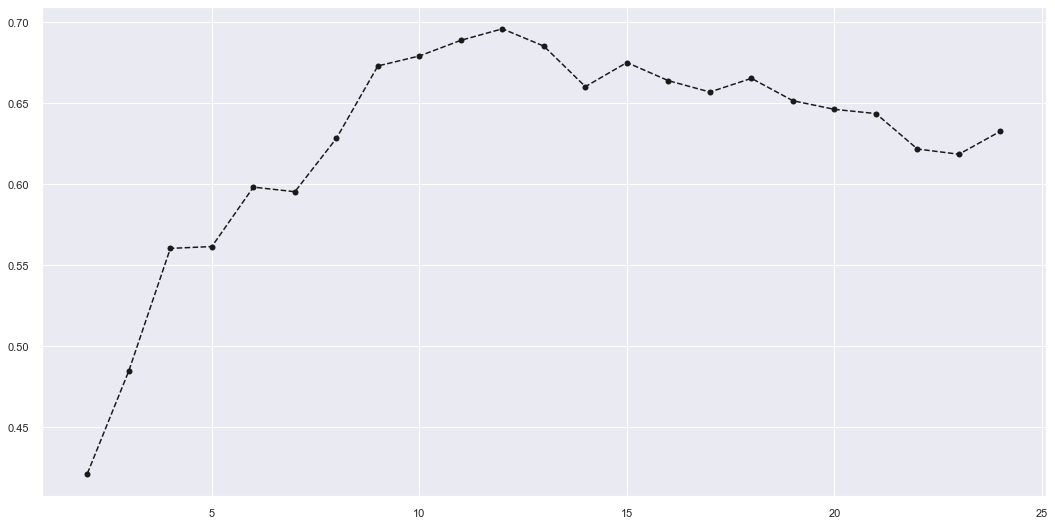

In [70]:
plt.plot(clusters, hc_list, linestyle='--', marker='o', color='k')

## 7.4 DBSCAN

In [71]:
eps = 2
min_samples = 20

# model definition
dbscan_model = c.DBSCAN(eps=eps, min_samples=min_samples)

# model training & predict
labels = dbscan_model.fit_predict(X)

sil = m.silhouette_score(X, labels, metric='euclidean')
sil

0.7020994

In [72]:
unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
      dtype=int64)

In [73]:
from sklearn.neighbors import NearestNeighbors

In [74]:
neighbors = NearestNeighbors(n_neighbors=min_samples).fit(X)
distances, indices = neighbors.kneighbors(X)

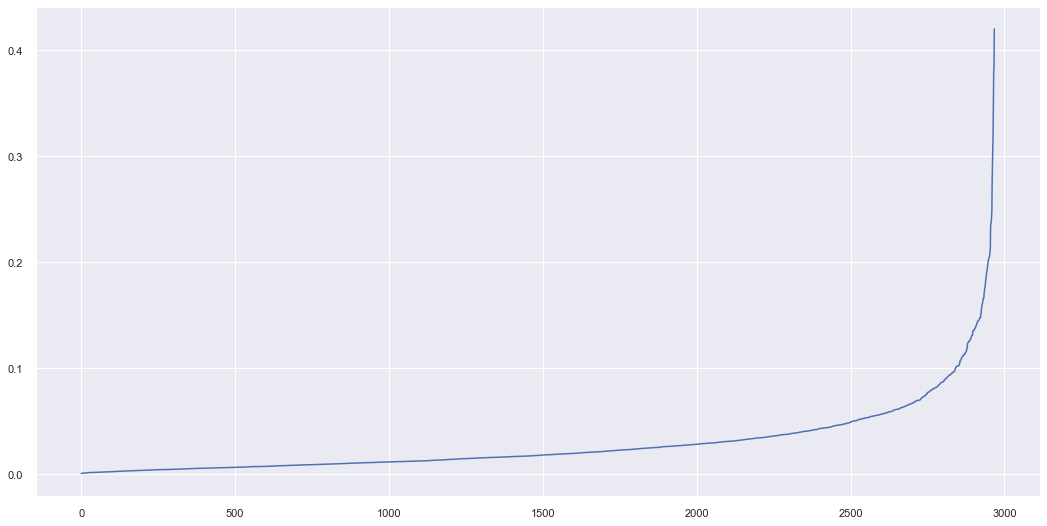

In [75]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

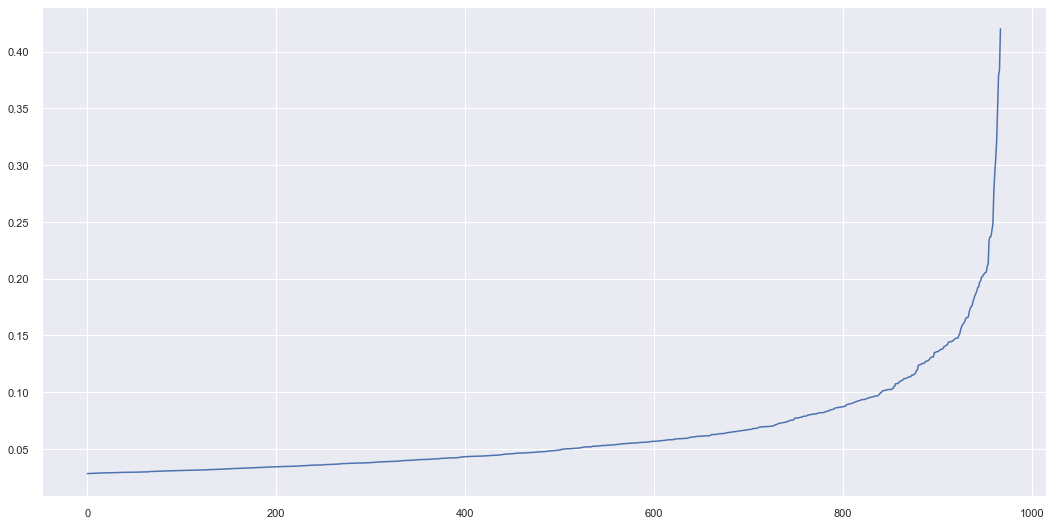

In [76]:
# zoom
plt.plot(distances[2000:])

In [77]:
dbscan_list = [ 0.622034, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000]

## 7.5 Results

In [78]:
df_results = pd.DataFrame({'Kmeans': kmeans_list,
                          'GMM': gmm_list,
                          'HC':hc_list}).T
                          #'DBSCAN':dbscan_list}).T
df_results.columns = clusters

In [79]:
df_results.style.highlight_max(color='lightgreen', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
Kmeans,0.426632,0.487805,0.558806,0.572818,0.614562,0.636495,0.628773,0.673057,0.679218,0.688896,0.696007,0.685289,0.700193,0.675175,0.664064,0.623808,0.645243,0.641605,0.641979,0.645181,0.617392,0.624882,0.604113
GMM,0.401285,0.487805,0.560351,0.572818,0.557823,0.595869,0.632320,0.611440,0.657791,0.689842,0.651188,0.661884,0.679713,0.636717,0.655552,0.663377,0.643610,0.602151,0.659858,0.637201,0.617769,0.620010,0.649393
HC,0.421236,0.484713,0.560351,0.561478,0.598200,0.595346,0.628300,0.673057,0.679218,0.688896,0.696007,0.685289,0.660271,0.675175,0.663941,0.656947,0.665387,0.651568,0.646238,0.643633,0.621732,0.618502,0.632714


## 7.3 Silhouette Analysis

 For K = 2. Silhouette Score: 0.4212355613708496
 For K = 3. Silhouette Score: 0.48471349477767944
 For K = 4. Silhouette Score: 0.5603510737419128
 For K = 5. Silhouette Score: 0.561477541923523
 For K = 6. Silhouette Score: 0.5981996655464172
 For K = 7. Silhouette Score: 0.5953463912010193
 For K = 8. Silhouette Score: 0.6283002495765686
 For K = 9. Silhouette Score: 0.6730566024780273
 For K = 10. Silhouette Score: 0.6792176365852356
 For K = 11. Silhouette Score: 0.6888957619667053
 For K = 12. Silhouette Score: 0.6960068345069885
 For K = 13. Silhouette Score: 0.6852886080741882
 For K = 14. Silhouette Score: 0.6602712273597717
 For K = 15. Silhouette Score: 0.6751750707626343


IndexError: index 7 is out of bounds for axis 0 with size 7

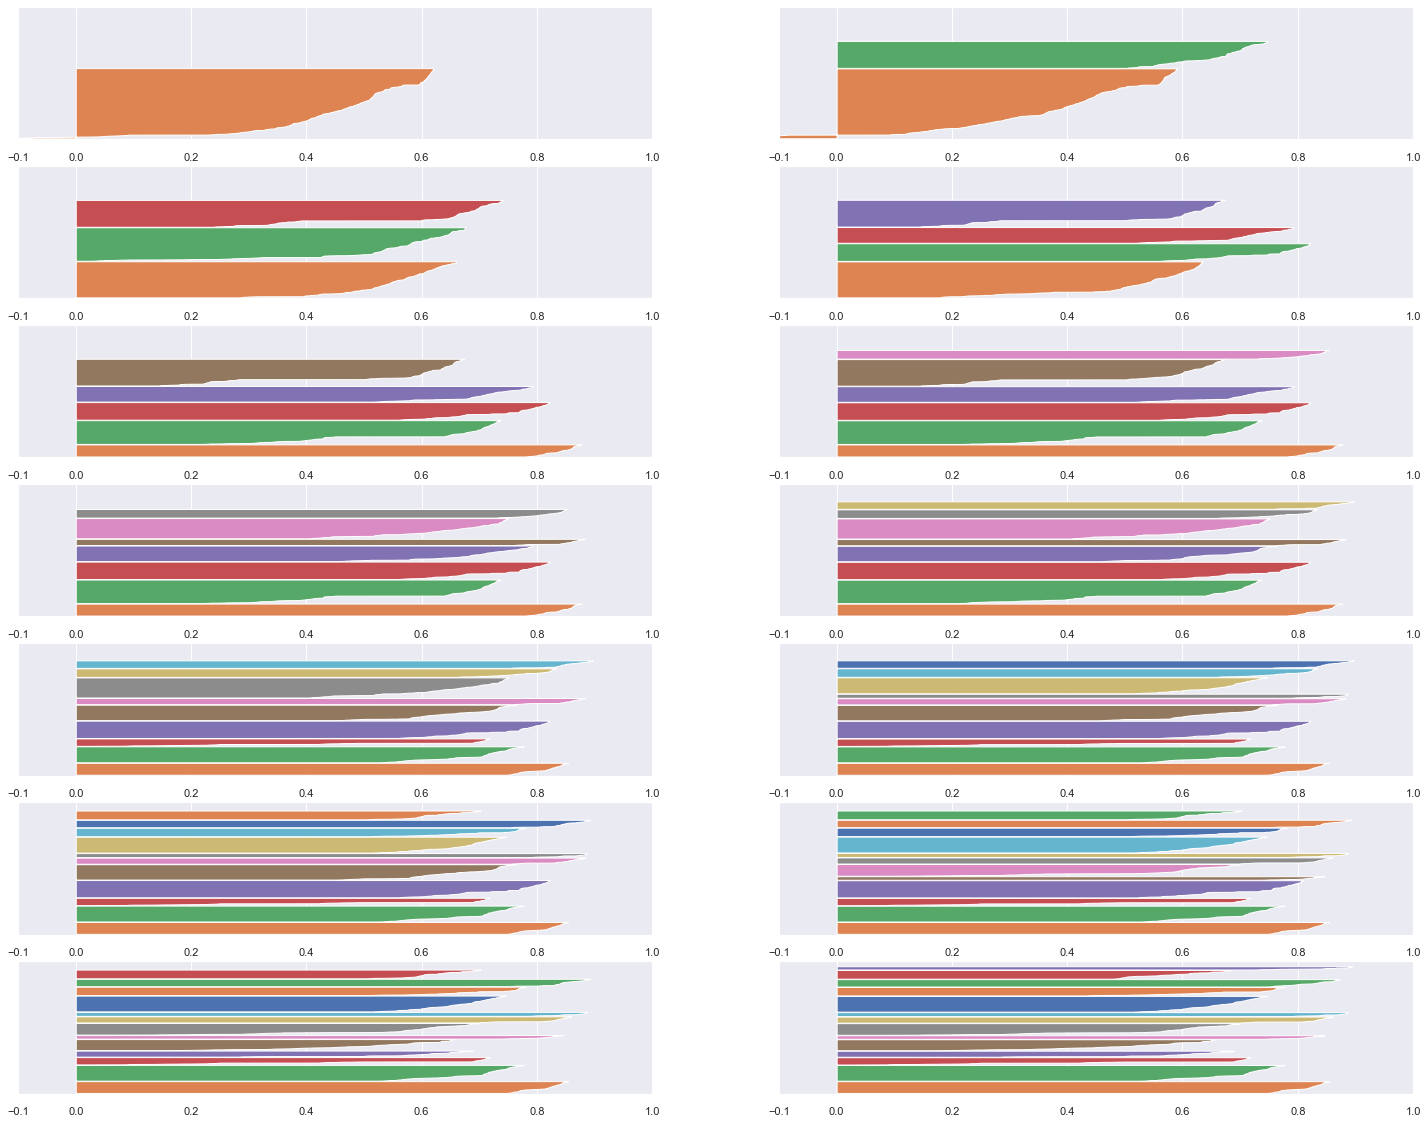

In [80]:
fig, ax = plt.subplots( 7, 2 )
fig.set_size_inches( 25, 20 )

for k in clusters:
    q, mod = divmod( k, 2 )
    
    ax[q-1, mod].set_xlim( [ -0.1, 1] )
    ax[q-1, mod].set_ylim( [ 0, len( X ) + ( k+1 )*10] )
    
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # performance
    ss = m.silhouette_score( X, labels, metric='euclidean' )
    print( ' For K = {}. Silhouette Score: {}'.format( k, ss ) )

    samples_silhouette_values = m.silhouette_samples( X, labels )

    y_lower = 10
    for i in range( k ):

        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[ labels == i]
        
        # sort values
        ith_samples_silhouette_values.sort()

        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap( 'Spectral' )
        color = cmap( i / k )

        ax[q-1, mod].fill_betweenx( np.arange( y_lower, y_upper ), 0, ith_samples_silhouette_values  )
        
        y_lower = y_upper + 10
        
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks( [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 8.0 Model Training

## 8.1 Final Model

### K-Means

In [109]:
# model definition
k = 9
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model traiing
kmeans.fit(X)

# clustering
labels =kmeans.labels_

### GMM

In [86]:
# model definition
#k = 8
#gmm_model = mx.GaussianMixture(n_components=k, random_state=42)

# model traiing
#gmm_model.fit(X)

# clustering
#labels =gmm_model.predict(X)

## 8.2 Cluster Validation

In [110]:
## SS (Silhouette Score)
print('SS value: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

SS value: 0.6730566024780273


# 9.0 Cluster Analysis

In [111]:
df9 = X.copy()
df92 = df4.copy()
df9['cluster'] = labels

In [112]:
#df9['cluster'] = labels
df9.head()

,embedding_x,embedding_y,cluster
0,11.351,16.477,0
1,18.303,8.047,4
2,11.598,17.452,0
3,2.455,7.087,1
4,-4.883,9.617,7


## 9.1 Visualization Inspection

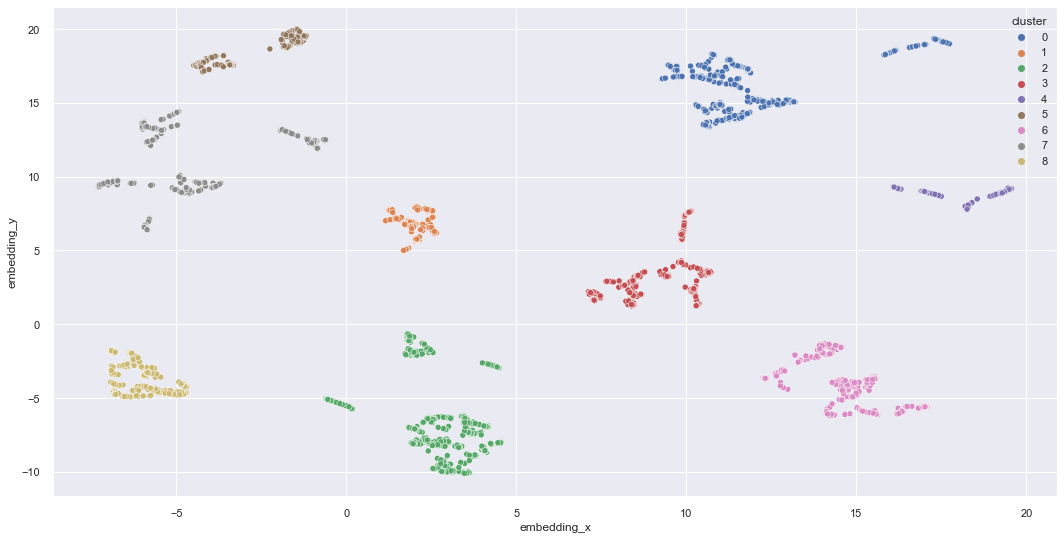

In [113]:
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', data=df9, palette='deep');

In [ ]:
#visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
#visualizer.fit(X)
#visualizer.finalize()

## 9.2 2d Plot

In [ ]:
#df_viz = df9.drop('customer_id', axis=1)
#sns.pairplot(df_viz, hue='cluster')

## 9.3 UMAP

In [ ]:
#reducer = umap.UMAP(n_neighbors=20, random_state=42)
#embedding = reducer.fit_transform(X)

# embedding
#df_viz['embedding_x'] = embedding[:, 0]
#df_viz['embedding_y'] = embedding[:, 1]

#plot UMAP
#sns.scatterplot(x='embedding_x',y='embedding_y', hue='cluster', palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())), data=df_viz)

## 9.4 Cluster Profile

In [115]:
df92 = df4[cols_selected].copy()
df92['cluster'] = labels
df92.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,5391.210,372.000,297.000,17.000,40.000,0
1,13047,3232.590,56.000,171.000,0.028,35.000,4
2,12583,6705.380,2.000,232.000,0.040,50.000,0
3,13748,948.250,95.000,28.000,0.018,0.000,1
4,15100,876.000,333.000,3.000,0.073,22.000,7


In [116]:
# Number of customers
df_cluster = df92[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Avg gross revenue
df_avg_gross_revenue = df92[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency days
df_avg_recency_days = df92[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Avg invoice_no
df_qtde_products = df92[['qtde_products','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_qtde_products, how='inner', on='cluster')

# frequency 
df_frequency = df92[['frequency','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_frequency, how='inner', on='cluster')

# returns
df_qtde_returns = df92[['qtde_returns','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_qtde_returns, how='inner', on='cluster')

df_cluster.sort_values('gross_revenue', ascending=False)

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
0,0,468,15.768,8835.897,21.438,424.088,0.095,149.271
4,4,145,4.885,3164.115,34.428,173.841,0.060,23.483
3,3,360,12.129,2395.119,45.428,127.067,0.045,26.867
2,2,545,18.363,2048.797,58.040,65.305,0.046,11.897
6,6,404,13.612,1689.073,54.809,89.176,0.050,11.542
8,8,279,9.400,954.047,77.362,36.530,0.082,5.710
1,1,175,5.896,827.410,92.023,26.811,0.162,22.869
5,5,200,6.739,647.934,47.280,11.510,0.026,0.845
7,7,392,13.208,505.606,149.426,15.513,0.427,9.444


- 0 - Cluster -> Insiders
- 4 - Cluster -> More products
- 3 - Cluster -> Spend more
- 2 - Cluster -> Even more products
- 6 - Cluster -> less days
- 8 - Cluster -> less 1k
- 1 - Cluster -> returners
- 5 - Cluster -> buy more
- 7 - Cluster -> less recency

# 10.0 Exploratory Data Analisys

In [98]:
df10 = df92.copy()

## 10.1 Hipóteses de Negócio

### Hipóteses de compra

1. Os clientes do cluster insiders usam cartão de crédito em 80% das compras
2. Os clientes do cluster insiders possuem um ticket mpedio de 10% acima do cluster More Products
3. Os clientes do cluster insiders posseum um basket size acima de 5 produtos.
4. Os clientes do cluster insidersposseum um volume (produtos) de compras acima de 10% do total de compras.
5. Os clientes do cluster insidersposseum um volume (faturamento) de compras acima de 10% do total de compras.
6. Os clientes do cluster insiders tem um número de devoluções abaixo da média da base total de clientes
7. A mediana dos preços do faturamentos pelos clientes do cluster insiders é 10% maior do que a mediana de todos do faturamento geral.
8. A quantidade dos clientes insiders que estão concentrados no 3 quartil.

### Hipóteses de cliente

1. 60% dos clientes do clsuter insiders possuem o estado civivl de solteiro.
2. 10% dos clientes do cluster insiders estão na faixa de 24-35 anos.
3. 40% das localidades de entrega do cluster insiders estão dentro de um raio de 50km.
4. 5% dos clientes do cluster insiders recebem mais de 100 mil dólares anualmente.
5. 90% dos clientes do cluster insiders tem ensino superior completo.

### Hipóteses de produto

1. 30% de todos os produtos em pacotes grandes são comprados pelos clientes do cluster insiders.
2. A mediana dos preços do faturamentos pelos clientes do cluster insiders é 10% maior do que a mediana de todos do faturamento geral.
3. O percentil do gmv dos clientes insiders.
4. O peso médio dos produtos comprados pelos clientes do cluster insiders pe maior do que o peso médio dos outros clusters.
5. A idade média dos produtos comprados pelos clientes do cluster insiders é menor do que 15 dias. 

## 10.2 Priorização das Hipóteses

1. **Os clientes do cluster insiders posseum um volume (produtos) de compras acima de 10% do total de compras.**
2. **Os clientes do cluster insiders posseum um volume (faturamento) de compras acima de 10% do total de compras.**
3. **Os clientes do cluster insiders tem um número de devoluções abaixo da média da base total de clientes**
4. **A mediana dos preços do faturamentos pelos clientes do cluster insiders é 10% maior do que a mediana de todos do faturamento geral.**
5. **A quantidade dos clientes insiders que estão concentrados no 3 quartil.**

## 10.3 Validação das Hipóteses

### H1. **Os clientes do cluster insiders possuem um volume (produtos) de compras acima de 10% do total de compras**
**Verdadeira** - O cluster insiders possuem um volume de compras (produtos) de 54% do total de compras

In [99]:
# soma de qtde produtos do insiders
df_insiders_sales = df10.loc[df10['cluster'] == 0, 'qtde_products'].sum()
# soma de qtde de produtos total
df_sales_total = df10.loc[:, 'qtde_products'].sum()
# soma de produtos total
print('Sales Insiders: {:.2f}%'.format(100*df_insiders_sales/df_sales_total))

Sales Insiders: 54.48%


### H2. **Os clientes do cluster insidersposseum um volume (faturamento) de compras acima de 10% do total de compras.**
**Verdadeira** - O cluster insiders possui um volume de GMV de 52%

In [100]:
# soma do gross revenue do insiders
df_gmv_insiders = df10.loc[df10['cluster'] == 0, 'gross_revenue'].sum()
# soma de gross revenue total
df_gmv_total = df10.loc[:, 'gross_revenue'].sum()
print('GMV Insiders: {:.2f}%'.format(100*df_gmv_insiders/df_gmv_total))

GMV Insiders: 51.73%


### H3. **Os clientes do cluster insiders tem um número de devoluções médio abaixo da média da base total de clientes**
**Falsa** - O cluster insiders tem uma média de devoluções acima da média geral.

In [101]:
# media de devolução do insiders
df_returns_insiders = df10.loc[df10['cluster'] == 0, 'qtde_returns'].mean()
# media de devoluções total
df_returns_total = df10['qtde_returns'].mean()
print('Avg returns insiders: {} vs Avg returns total: {}'.format(np.round(df_returns_insiders,0),np.round(df_returns_total,0)))

Avg returns insiders: 149.0 vs Avg returns total: 35.0


### H4. A mediana dos preços do faturamentos pelos clientes do cluster insiders é 10% maior do que a mediana de todos do faturamento geral.
**Verdadeira** - A mediana do faturamento é 276% acima da média.

In [102]:
# mediana de gmv insiders
df_median_gmv_insiders = df10.loc[df10['cluster'] == 0, 'gross_revenue'].median()

# mediana de gmv do total
df_median_gmv_total = df10['gross_revenue'].median()

gmv_diff = (df_median_gmv_insiders-df_median_gmv_total)/df_median_gmv_total

print('Median Diff {:.2f}%'.format(100*gmv_diff))

Median Diff 276.22%


### H5. O GMV dos clientes insiders que estão concentrados no 3 quartil.
**Falsa** - O GMV do cluster insiders está concentrado no quartil 1

In [103]:
np.percentile(df10.loc[df10['cluster'] == 0, 'gross_revenue'], q=0.1)

617.5615499999993

In [104]:
np.percentile(df10.loc[df10['cluster'] == 0, 'gross_revenue'], q=0.9)

823.9843299999998

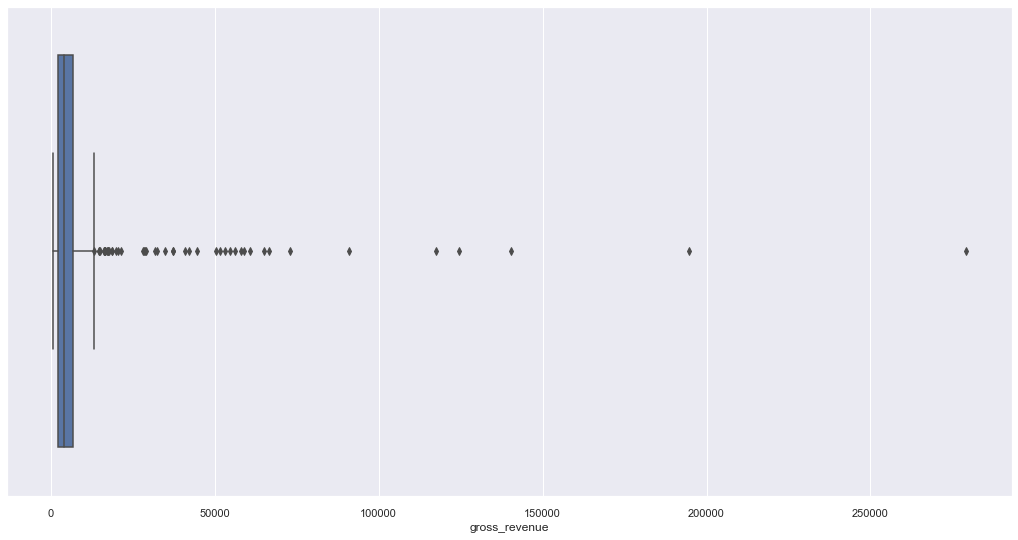

In [105]:
sns.boxplot(x=df10.loc[df10['cluster']==0, 'gross_revenue']);

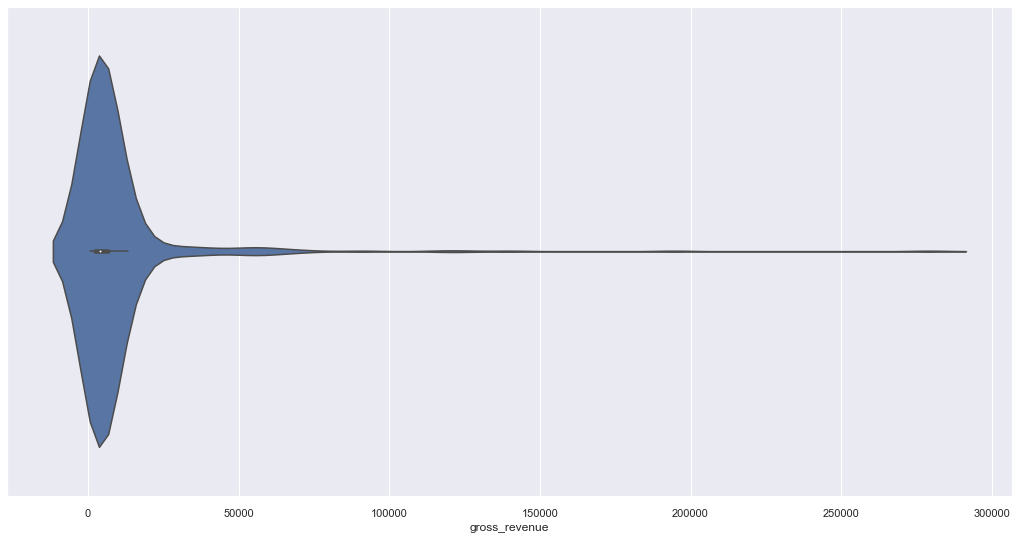

In [106]:
sns.violinplot(x=df10.loc[df10['cluster']==0, 'gross_revenue']);

## Perguntas de Negócio

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
2. Quantos clientes farão parte do grupo?
3. Quais as principais características desses clientes ?
4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
5. Qual a expectativa de faturamento desse grupo para os próximos meses ?
6. Quais as condições para uma pessoa ser elegível ao Insiders ?
7. Quais as condições para uma pessoa ser removida do Insiders ?
8. Qual a garantia que o programa Insiders é melhor que o restante da base ?
9. Quais ações o time de marketing pode realizar para aumentar o faturamento?

## 10.4 Quadro de Respostas

### 1. Quem são as pessoas elegíveis para participar do programa de Insiders ?

In [107]:
df10.loc[df10['cluster'] == 0, 'customer_id'].head()

0     17850
2     12583
6     14688
8     15311
12    16029
Name: customer_id, dtype: int64

### 2. Quantos clientes farão parte do grupo?

In [108]:
df10.loc[df10['cluster'] == 0, 'customer_id'].size

468

### 3. Quais as principais características desses clientes ?

- Número de customers: 468 (16% do customers )
- Faturamento médio: 8836
- Recência média: 21 dias
- Média de Produtos comprados: 424 produtos
- Frequência de Produtos comprados: 0.09 produtos/dia
- Receita em média: $8836.13,00 dólares

### 4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?

In [120]:
df_insiders_gmv = df10.loc[df10['cluster'] ==0, 'gross_revenue'].sum()
df_all_gmv = df10.loc[:, 'gross_revenue'].sum()
print('GMV from Insiders: {:.2f}%'.format(100*df_insiders_gmv/df_all_gmv))

GMV from Insiders: 51.73%


### 6. Quais as condições para uma pessoa ser elegível ao Insiders ?

### 7. Quais as condições para uma pessoa ser removida do Insiders ?

### 8. Qual a garantia que o programa Insiders é melhor que o restante da base ?

### 9. Quais ações o time de marketing pode realizar para aumentar o faturamento?

# 11.0 Deploy